In [2]:
!ln -s ~/COCO/ ./COCO

In [3]:

import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import utils
from coco_utils import get_coco
import transforms

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load the COCO 2017 train and val sets. We use the CocoDetection class definition
# from ./coco_utils.py, not the original torchvision.CocoDetection class. Also, we
# use transforms from ./transforms, not torchvision.transforms, because they need
# to transform the bboxes and masks along with the image.

coco_path = "./COCO"

transform = transforms.Compose([
    transforms.ToTensor()
])

print('Loading COCO train, val datasets...')
coco_train_dataset = get_coco(coco_path, 'train', transform)
coco_val_dataset = get_coco(coco_path, 'val', transform)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = torch.utils.data.DataLoader(coco_val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

Loading pretrained model...
Loading COCO train, val datasets...
loading annotations into memory...
Done (t=37.78s)
creating index...
index created!
loading annotations into memory...
Done (t=1.97s)
creating index...
index created!


In [4]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:2


In [5]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [6]:
images, targets = next(iter(val_dataloader))

print(type(images), len(images))
print(images[0].shape)
print(type(targets), len(targets))
print(targets[0].keys())
# print()
# images = images.to(device)

images = [ img.to(device) for img in images ]
predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

<class 'tuple'> 4
torch.Size([3, 426, 640])
<class 'tuple'> 4
dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([100, 4])
Labels shape: torch.Size([100])
Scores shape: torch.Size([100])
Masks shape: torch.Size([100, 1, 426, 640])


In [7]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

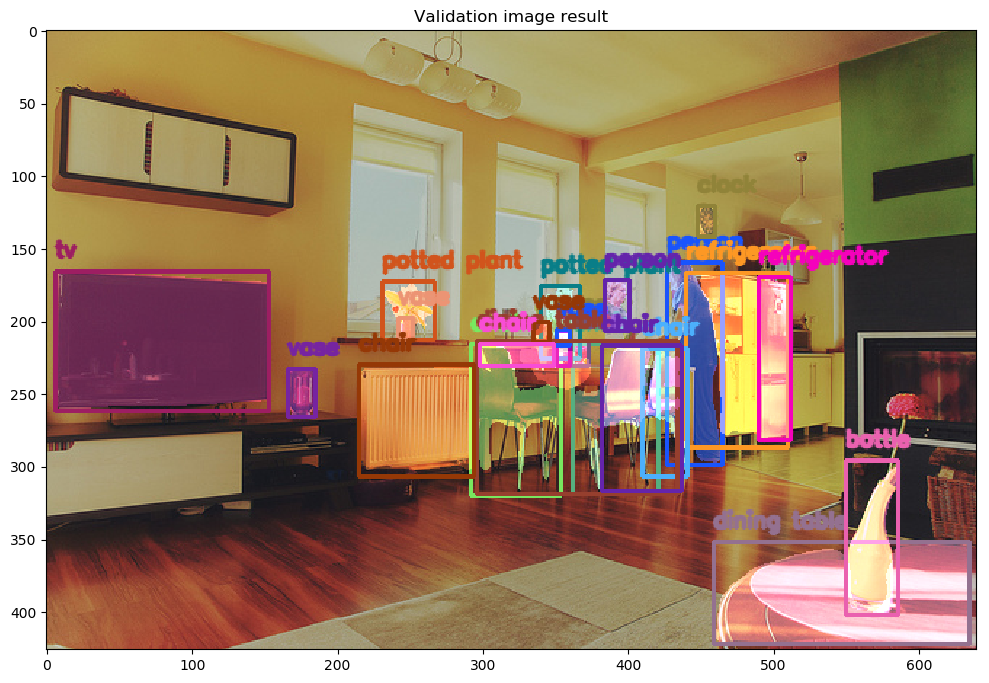

In [8]:

from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

In [10]:
from engine import evaluate
results = evaluate(model, val_dataloader, device)

Test:  [   0/1250]  eta: 2:07:42  model_time: 0.7071 (0.7071)  evaluator_time: 0.5517 (0.5517)  time: 6.1303  data: 0.4237  max mem: 0
Test:  [ 100/1250]  eta: 0:26:33  model_time: 0.4792 (0.4967)  evaluator_time: 0.1888 (0.2832)  time: 1.5557  data: 0.8048  max mem: 0
Test:  [ 200/1250]  eta: 0:23:32  model_time: 0.4807 (0.5005)  evaluator_time: 0.2576 (0.2742)  time: 1.1708  data: 0.4154  max mem: 0
Test:  [ 300/1250]  eta: 0:20:56  model_time: 0.5056 (0.4965)  evaluator_time: 0.2880 (0.2662)  time: 1.4042  data: 0.5783  max mem: 0
Test:  [ 400/1250]  eta: 0:18:43  model_time: 0.5572 (0.4975)  evaluator_time: 0.2891 (0.2657)  time: 1.4700  data: 0.5940  max mem: 0
Test:  [ 500/1250]  eta: 0:16:30  model_time: 0.4536 (0.4912)  evaluator_time: 0.2300 (0.2582)  time: 1.3308  data: 0.6276  max mem: 0
Test:  [ 600/1250]  eta: 0:14:20  model_time: 0.4918 (0.4881)  evaluator_time: 0.2215 (0.2567)  time: 1.2673  data: 0.5862  max mem: 0
Test:  [ 700/1250]  eta: 0:12:10  model_time: 0.4802 (0

In [1]:
results = open("output_coco.txt", "r")
print(results.read())

Test:  [   0/1250]  eta: 2:07:42  model_time: 0.7071 (0.7071)  evaluator_time: 0.5517 (0.5517)  time: 6.1303  data: 0.4237  max mem: 0
Test:  [ 100/1250]  eta: 0:26:33  model_time: 0.4792 (0.4967)  evaluator_time: 0.1888 (0.2832)  time: 1.5557  data: 0.8048  max mem: 0
Test:  [ 200/1250]  eta: 0:23:32  model_time: 0.4807 (0.5005)  evaluator_time: 0.2576 (0.2742)  time: 1.1708  data: 0.4154  max mem: 0
Test:  [ 300/1250]  eta: 0:20:56  model_time: 0.5056 (0.4965)  evaluator_time: 0.2880 (0.2662)  time: 1.4042  data: 0.5783  max mem: 0
Test:  [ 400/1250]  eta: 0:18:43  model_time: 0.5572 (0.4975)  evaluator_time: 0.2891 (0.2657)  time: 1.4700  data: 0.5940  max mem: 0
Test:  [ 500/1250]  eta: 0:16:30  model_time: 0.4536 (0.4912)  evaluator_time: 0.2300 (0.2582)  time: 1.3308  data: 0.6276  max mem: 0
Test:  [ 600/1250]  eta: 0:14:20  model_time: 0.4918 (0.4881)  evaluator_time: 0.2215 (0.2567)  time: 1.2673  data: 0.5862  max mem: 0
Test:  [ 700/1250]  eta: 0:12:10  model_time: 0.4802 (0